# Environment Setup

First, we import the SymPy libraray that will allow us to develop and manipulate symbolic expressions.

In [30]:
import sympy as sp

In SymPy, we initialize printing so that all of the mathematical expressions can be rendered in standard mathematical notation.

In [31]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)

Now, we declare the symbols (link lenghts, joint variables etc.) which will be used for further formulation.

In [32]:
from sympy.physics.mechanics import dynamicsymbols
theta1, theta2, l1, l2, theta, alpha, a, d = dynamicsymbols('theta1 theta2 l1 l2 theta alpha a d')
theta1, theta2, l1, l2, theta, alpha, a, d 

(theta1, theta2, l1, l2, theta, alpha, a, d)

# Kinematics Using DH Method

We assign the frames to our manipulator according to DH classic convention. DH method provides a convenient way to express the position and orienation of a rigid-body in matrix forms using the relevant link lengths, joint angles, twist angles and joint offsets.

|i   	|$\alpha_i$   	|$a_i$ 	|$d_i$	|$\theta_i$   	|
|---	|-----------	|---	|---	|-----------	|
|1   	|0          	|$l_1$	|0   	|$\theta_1$   	|
|2   	|0   	        |$l_2$ 	|0   	|$\theta_2$   	|

*DH Table*: 
The DH table for 2-Link Planar Mnipulator shown above can be formulated as,

 
i : joint number,  $\alpha_i$  : twist angle,  $a_i$ : length of link  i ,  $d_i$ : joint offset and  $\theta_i$ : joint angle.

## Homogenous Transformation
The standard homogenous transformation matrix (transformation from base to tip frame in the DH notation) is represented as (see slides),

In [33]:
rot = sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha)],
                 [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha)],
                 [0, sp.sin(alpha), sp.cos(alpha)]])

trans = sp.Matrix([a*sp.cos(theta),a*sp.sin(theta),d])

last_row = sp.Matrix([[0, 0, 0, 1]])

m = sp.Matrix.vstack(sp.Matrix.hstack(rot, trans), last_row)
m


Matrix([
[cos(theta), -sin(theta)*cos(alpha),  sin(alpha)*sin(theta), a*cos(theta)],
[sin(theta),  cos(alpha)*cos(theta), -sin(alpha)*cos(theta), a*sin(theta)],
[         0,             sin(alpha),             cos(alpha),            d],
[         0,                      0,                      0,            1]])

#### Transformation: frame '0' to '1'¶

In [34]:
m01 = m.subs({alpha:0, a:l1, theta:theta1, d:0})
m01

Matrix([
[cos(theta1), -sin(theta1), 0, l1*cos(theta1)],
[sin(theta1),  cos(theta1), 0, l1*sin(theta1)],
[          0,            0, 1,              0],
[          0,            0, 0,              1]])

#### Transformation: frame '1' to '2'¶

In [35]:
m12 = m.subs({alpha:0, a:l2, theta:theta2, d:0})
m12

Matrix([
[cos(theta2), -sin(theta2), 0, l2*cos(theta2)],
[sin(theta2),  cos(theta2), 0, l2*sin(theta2)],
[          0,            0, 1,              0],
[          0,            0, 0,              1]])

#### Homogenous transformation: frame '0' to '2'

In [36]:
m02 = (m01*m12)
m02

Matrix([
[-sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2), -sin(theta1)*cos(theta2) - sin(theta2)*cos(theta1), 0, l1*cos(theta1) - l2*sin(theta1)*sin(theta2) + l2*cos(theta1)*cos(theta2)],
[ sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1), -sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2), 0, l1*sin(theta1) + l2*sin(theta1)*cos(theta2) + l2*sin(theta2)*cos(theta1)],
[                                                 0,                                                  0, 1,                                                                        0],
[                                                 0,                                                  0, 0,                                                                        1]])

Using Sympy's built-in simplification methods, we simplify the transformation matrix as

In [37]:
m02.simplify()

m02

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), 0, l1*cos(theta1) + l2*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), 0, l1*sin(theta1) + l2*sin(theta1 + theta2)],
[                   0,                     0, 1,                                        0],
[                   0,                     0, 0,                                        1]])

The first two columns in above matrix describe the orienation of the tip of manipulator in X, Y and Z directions. Whereas, the last column represnts the position in respective directions. As our manipulator does not carry any end-effector, analyses of orientaion becomes meaningless.

## Forward Kinematic Equations
Tip position can be expressed as,

#### Position in x-direction

In [38]:
px = m02[0,3]
px

l1*cos(theta1) + l2*cos(theta1 + theta2)

#### Position in y-direction

In [39]:
py = m02[1,3]
py

l1*sin(theta1) + l2*sin(theta1 + theta2)

## Evaluation of tip position
To evaluate tip position numerically, we make use of Sympy's lambdify function which takes  $l_1$ ,  $l_2$ ,  $\theta_1$  and  $\theta_2$  as arguments.

In [27]:
fx = sp.lambdify((l1, l2, theta1, theta2), px, 'numpy')
fy = sp.lambdify((l1, l2, theta1, theta2), py, 'numpy')

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
d2r = np.deg2rad

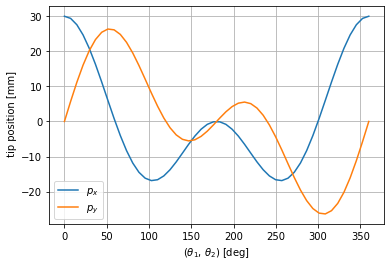

In [29]:
theta1s = np.linspace(d2r(0), d2r(360)) # desired range of motion for joint 1
theta2s = np.linspace(d2r(0), d2r(360)) # desired range of motion for joint 2

zx = np.array(fx(15.0, 15.0, theta1s, theta2s))
zy = np.array(fy(15.0, 15.0, theta1s, theta2s))

fig, ax1 = plt.subplots()
ax1.plot(np.rad2deg(theta1s), zx, label = r'$p_x$')
ax1.plot(np.rad2deg(theta1s), zy, label = r'$p_y$')
ax1.set_xlabel(r'($\theta_1$, $\theta_2$) [deg]')
ax1.set_ylabel(r' tip position [mm]')
plt.legend()
plt.grid()